## Import Library

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.utils.vis_utils import plot_model
import tensorflow

In [21]:
print("Num GPUs Available", len(tensorflow.config.experimental.list_physical_devices('GPU')))

Num GPUs Available 1


## Data

In [22]:
dataframe = pd.read_csv('HR.csv',usecols=[1],engine='python')

In [23]:
dataset = dataframe.values

In [24]:
dataset = dataset[:10000]

## Scaling

In [25]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

## Train Test Split

In [26]:
train = dataset[0:8000]
test = dataset[8000:10000]

In [27]:
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [28]:
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [29]:
testX.shape

(1998, 1)

In [30]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

## LSTM

In [ ]:
model = Sequential()
model.add(LSTM(units = 50,return_sequences = True, input_shape=(1, look_back)))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(trainX, trainY,validation_data=(testX, testY), epochs=20, batch_size=1, verbose=2)

Epoch 1/20
7998/7998 - 84s - loss: 0.0038 - val_loss: 0.0016 - 84s/epoch - 11ms/step
Epoch 2/20
7998/7998 - 76s - loss: 0.0015 - val_loss: 0.0013 - 76s/epoch - 9ms/step
Epoch 3/20
7998/7998 - 75s - loss: 0.0014 - val_loss: 0.0021 - 75s/epoch - 9ms/step
Epoch 4/20
7998/7998 - 75s - loss: 0.0014 - val_loss: 0.0013 - 75s/epoch - 9ms/step
Epoch 5/20


## Prediction

In [ ]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 3.25 RMSE
Test Score: 4.20 RMSE


In [ ]:
test1 = dataset[10001:11000]
test1X, test1Y = create_dataset(test1, look_back)

In [ ]:
test1Predict = model.predict(test1X)
# invert predictions
testPredict = scaler.inverse_transform(test1Predict)
testY = scaler.inverse_transform([test1Y])
# calculate root mean squared error
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

ValueError: ignored

Model Details

In [ ]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 50)             10400     
                                                                 
 dropout (Dropout)           (None, 1, 50)             0         
                                                                 
 lstm_1 (LSTM)               (None, 1, 50)             20200     
                                                                 
 dropout_1 (Dropout)         (None, 1, 50)             0         
                                                                 
 lstm_2 (LSTM)               (None, 1, 50)             20200     
                                                                 
 dropout_2 (Dropout)         (None, 1, 50)             0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                2

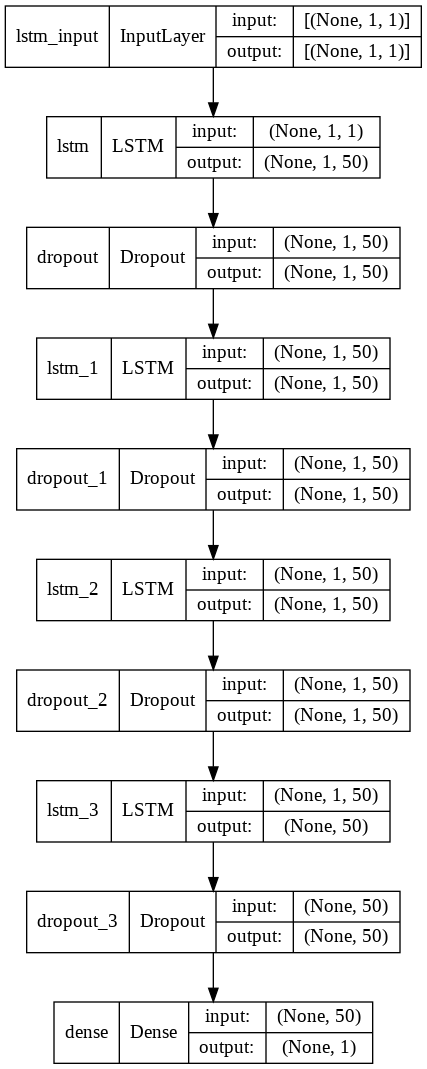

In [ ]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

### Plot

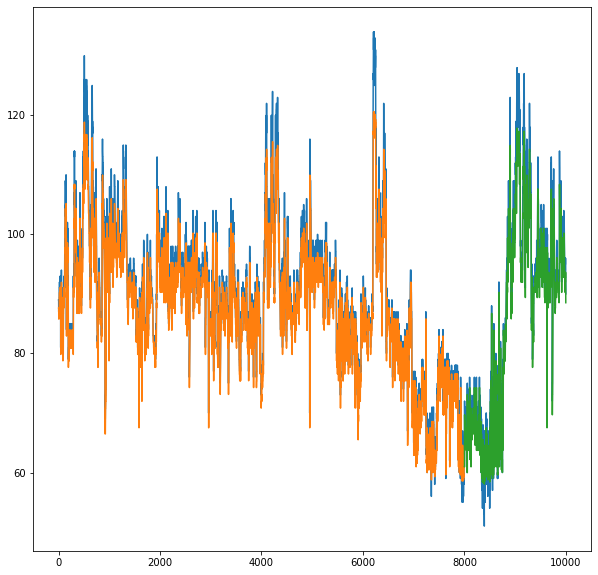

In [ ]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.rcParams["figure.figsize"] = (10,10)
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [ ]:
print(history.history.keys())

dict_keys(['loss', 'val_loss'])


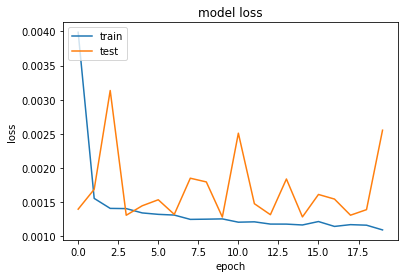

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()